# CalIt2 building people counts dataset

In [63]:
import pandas as pd
import os
from typing import Final
from config import data_raw_folder, data_processed_folder
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20, 10)

In [64]:
dataset_collection_name = "CalIt2"
source_folder = os.path.join(data_raw_folder, "UCI ML Repository/CalIt2")
target_folder = data_processed_folder

Metdata handling

In [65]:
# type
DatasetMetadataRecord = {
    "collection_name": str,
    "dataset_name": str,
    "train_path": str,
    "test_path": str,
    "dataset_type": str,
    "datetime_index": bool,
    "split_at": int,
    "train_type": str,
    "train_is_normal": bool,
    "input_type": str,
    "length": int
}

class DatasetMetadata:
    """
    ATTENTION: Not thread-safe! There is no check for changes to the underlying `dataset.csv` file while this class is loaded.
    """
    
    FILENAME: Final[str] = "datasets.csv"
    
    _filepath: str
    _df: pd.DataFrame
    _dirty: bool

    def __init__(self, target_folder: str):
        self._filepath = os.path.join(target_folder, self.FILENAME)
        self._dirty = False
        if not os.path.isfile(self._filepath):
            self._df = self._create_metadata_file()
        else:
            self.refresh(force = True)
    
    def __enter__(self) -> 'DatasetMetadata':
        return self
    
    def __exit__(self, exception_type, exception_value, exception_traceback) -> 'DatasetMetadata':
        self.save()
        return self
    
    def __repr__(self) -> str:
        return repr(self._df)
    
    def __str__(self) -> str:
        return str(self._df)
        
    def _create_metadata_file(self) -> pd.DataFrame:
        df_temp = pd.DataFrame(columns=["dataset_name", "collection_name", "train_path", "test_path", "dataset_type", "datetime_index", "split_at", "train_type", "train_is_normal", "input_type", "length"])
        df_temp.set_index(["collection_name", "dataset_name"], inplace=True)
        df_temp.to_csv(self._filepath)
        return df_temp
    
    def add_dataset(self,
        dataset_name: str,
        collection_name: str,
        train_path: str,
        test_path: str,
        dataset_type: str,
        datetime_index: bool,
        split_at: int,
        train_type: str,
        train_is_normal: bool,
        input_type: str,
        dataset_length: int
    ) -> None:
        df_new = pd.DataFrame({
            "train_path": train_path,
            "test_path": test_path,
            "dataset_type": dataset_type,
            "datetime_index": datetime_index,
            "split_at": split_at,
            "train_type": train_type,
            "train_is_normal": train_is_normal,
            "input_type": input_type,
            "length": dataset_length
        }, index=[(dataset_collection_name, dataset_name)])
        df = pd.concat([self._df, df_new], axis=0)
        df = df[~df.index.duplicated(keep = "last")]
        self._df = df
        self._dirty = True
    
    def add_datasets(self, datasets: list[DatasetMetadataRecord]) -> None:
        df_new = pd.DataFrame(datasets)
        df_new.set_index(["collection_name", "dataset_name"], inplace = True)
        df = pd.concat([self._df, df_new], axis=0)
        df = df[~df.index.duplicated(keep = "last")]
        self._df = df
        self._dirty = True
    
    def refresh(self, force: bool = False) -> None:
        if not force and self._dirty:
            raise Exception("There are unsaved changes in memory that would get lost by reading from disk again!")
        else:
            self._df = pd.read_csv(self._filepath, index_col=["collection_name", "dataset_name"])
    
    def save(self) -> None:
        self._df.to_csv(self._filepath)
        self._dirty = False

In [66]:
dataset_name = "CalIt2-traffic"
train_type = "unsupervised"
train_is_normal = False
input_type = "multivariate"
datetime_index = True
dataset_type = "real"

dm = DatasetMetadata(target_folder)

# create target directory
dataset_subfolder = os.path.join(target_folder, input_type, dataset_collection_name)
try:
    os.makedirs(dataset_subfolder)
    print(f"Created directories {dataset_subfolder}")
except FileExistsError:
    print(f"Directories {dataset_subfolder} already exist")
    pass

Directories data-processed/multivariate/CalIt2 already exist


In [67]:
# transform data 
df = pd.read_csv(os.path.join(source_folder, "CalIt2.data"), header=None)
df.columns = ["id", "date", "time", "count"]
df.insert(0, "timestamp", pd.to_datetime(df["date"] + " " + df["time"]))
df = df.drop(columns=["date", "time"])

# in flow
df_in = df[df["id"] == 9]
df_in = df_in.drop(columns=["id"])
df_in.columns = ["timestamp", "in_count"]

# out flow
df_out = df[df["id"] == 7]
df_out = df_out.drop(columns=["id"])
df_out.columns = ["timestamp", "out_count"]

df = pd.merge(df_in, df_out, on="timestamp", how="inner")

# read and add labels
df_events = pd.read_csv(os.path.join(source_folder, "CalIt2.events"), header=None)
df_events.columns = ["date", "begin", "end", "event_type"]
df_events.insert(0, "begin_timestamp", pd.to_datetime(df_events["date"] + " " + df_events["begin"]))
df_events.insert(1, "end_timestamp", pd.to_datetime(df_events["date"] + " " + df_events["end"]))
df_events = df_events.drop(columns=["date", "begin", "end", "event_type"])
# labelling
df["is_anomaly"] = 0
for _, (t1, t2) in df_events.iterrows():
    tmp = df[df["timestamp"] >= t1]
    tmp = tmp[tmp["timestamp"] <= t2]
    df.loc[tmp.index, "is_anomaly"] = 1

path = os.path.join(dataset_subfolder, f"{dataset_name}.test.csv")
dataset_length = len(df)
df.to_csv(path, index=False)
print(f"Processed dataset {dataset_name} -> {path}")

# save metadata
dm.add_dataset(
    dataset_name = dataset_name,
    collection_name = dataset_collection_name,
    train_path = None,
    test_path = path,
    dataset_type = dataset_type,
    datetime_index = datetime_index,
    split_at = None,
    train_type = train_type,
    train_is_normal = train_is_normal,
    input_type = input_type,
    dataset_length = dataset_length
)

dm.save()

Processed dataset CalIt2-traffic -> data-processed/multivariate/CalIt2/CalIt2-traffic.test.csv


In [68]:
dm.refresh()
dm._df.loc[dataset_collection_name]

,train_path,test_path,type,datetime_index,split_at,train_type,train_is_normal,input_type,length
dataset_name,,,,,,,,,
CalIt2-traffic,NaN,data-processed/multivariate/CalIt2/CalIt2-traf...,real,True,NaN,unsupervised,False,multivariate,5040


## Experimentation

In [31]:
df = pd.read_csv(os.path.join(source_folder, "CalIt2.data"), header=None)
df.columns = ["id", "date", "time", "count"]
df.insert(0, "timestamp", pd.to_datetime(df["date"] + " " + df["time"]))
df = df.drop(columns=["date", "time"])

# in flow
df_in = df[df["id"] == 9]
df_in = df_in.drop(columns=["id"])
df_in.columns = ["timestamp", "in_count"]

# out flow
df_out = df[df["id"] == 7]
df_out = df_out.drop(columns=["id"])
df_out.columns = ["timestamp", "out_count"]

df = pd.merge(df_in, df_out, on="timestamp", how="inner")
df

,timestamp,in_count,out_count
0,2005-07-24 00:00:00,0,0
1,2005-07-24 00:30:00,0,1
2,2005-07-24 01:00:00,0,0
3,2005-07-24 01:30:00,0,0
4,2005-07-24 02:00:00,0,0
...,...,...,...
5035,2005-11-05 21:30:00,0,0
5036,2005-11-05 22:00:00,0,3
5037,2005-11-05 22:30:00,0,0
5038,2005-11-05 23:00:00,0,0


In [43]:
df_events = pd.read_csv(os.path.join(source_folder, "CalIt2.events"), header=None)
df_events.columns = ["date", "begin", "end", "event_type"]
df_events.insert(0, "begin_timestamp", pd.to_datetime(df_events["date"] + " " + df_events["begin"]))
df_events.insert(1, "end_timestamp", pd.to_datetime(df_events["date"] + " " + df_events["end"]))
df_events = df_events.drop(columns=["date", "begin", "end", "event_type"])
df_events

,begin_timestamp,end_timestamp
0,2005-07-26 11:00:00,2005-07-26 14:00:00
1,2005-07-29 08:00:00,2005-07-29 11:00:00
2,2005-08-02 15:30:00,2005-08-02 16:30:00
3,2005-08-04 16:30:00,2005-08-04 17:30:00
4,2005-08-05 08:00:00,2005-08-05 11:00:00
5,2005-08-09 11:00:00,2005-08-09 14:00:00
6,2005-08-09 08:00:00,2005-08-09 16:00:00
7,2005-08-10 08:00:00,2005-08-10 16:00:00
8,2005-08-12 08:00:00,2005-08-12 11:00:00
9,2005-08-16 11:00:00,2005-08-16 14:00:00


In [47]:
# labelling
df["is_anomaly"] = 0
for _, (t1, t2) in df_events.iterrows():
    tmp = df[df["timestamp"] >= t1]
    tmp = tmp[tmp["timestamp"] <= t2]
    df.loc[tmp.index, "is_anomaly"] = 1
df

,timestamp,in_count,out_count,is_anomaly
0,2005-07-24 00:00:00,0,0,0
1,2005-07-24 00:30:00,0,1,0
2,2005-07-24 01:00:00,0,0,0
3,2005-07-24 01:30:00,0,0,0
4,2005-07-24 02:00:00,0,0,0
...,...,...,...,...
5035,2005-11-05 21:30:00,0,0,0
5036,2005-11-05 22:00:00,0,3,0
5037,2005-11-05 22:30:00,0,0,0
5038,2005-11-05 23:00:00,0,0,0


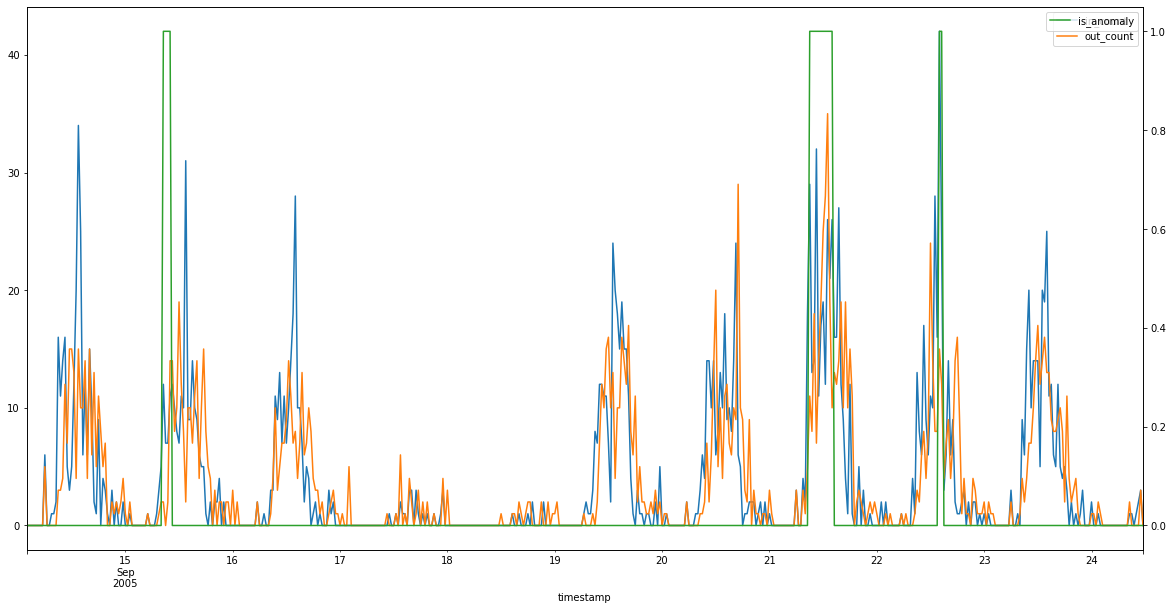

In [55]:
df_plot = df.iloc[2500:3000].copy()
df_plot = df_plot.set_index("timestamp")
df_plot.plot(y=["in_count", "out_count"])
df_plot["is_anomaly"].plot(secondary_y=True)
plt.legend()
plt.show()